In [91]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mutual_info_score, accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [92]:
def printest(args, value):
    return print( "{} : \n {} \n".format(args, value) )

# Logistic Regression - data preparation and model training

Churn prediction is about identifying customers who are likely to cancel their contracts soon. If the company can do that, it can offer discounts on these services in an effort to keep the users. Here we use the dataset of churn prediction for a telecom company.

- A value of 0 indicates that the customer did not churn (they stayed with the service).
- A value of 1 indicates that the customer did churn (they left the service).

In [93]:
df = pd.read_csv('Data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Convert 'TotalCharges' to numeric, replace non-numeric with NaN
df['TotalCharges'] = pd.to_numeric(df.TotalCharges, errors='coerce')
# Fill NaN values with zero
df['TotalCharges'] = df['TotalCharges'].fillna(0)

# lowering columns name and replace spaces by _
df.columns  = df.columns.str.lower().str.replace(' ', '_')


# boolean mask to select columns with object type (string)
obj_mask = df.dtypes == 'object' 
obj_columns = list(df.dtypes[obj_mask].index)

# lowering rows strings and replace spaces by _
for col in obj_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

# turn 'no' into 0 and 'yes' into 1
df.churn = (df.churn == 'yes').astype(int)

In [94]:
# split data in train, test, validation
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11)

# save target values
y_train = df_train['churn'].values
y_val = df_val['churn'].values

# take out the target values from the dataframe
del df_train['churn']
del df_val['churn']

In [95]:
# All categorical columns except 'customerid'
categorical_mask = df_train.dtypes == 'object'
categorical = list(df_train.dtypes[categorical_mask].index)
categorical.remove('customerid') 

# Manually add 'seniorcitizen' because it's an int boolean (0 or 1)
categorical.append('seniorcitizen')
printest('categorical', categorical)

# All numerical columns except 'seniorcitizen' because it's an int boolean
numerical_mask = df_train.dtypes != 'object'
numerical = list(df_train.dtypes[numerical_mask].index)
numerical.remove('seniorcitizen')
printest('numerical', numerical)

categorical : 
 ['gender', 'partner', 'dependents', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod', 'seniorcitizen'] 

numerical : 
 ['tenure', 'monthlycharges', 'totalcharges'] 



In [96]:
# transform dataframe to dict
train_dict = df_train[categorical + numerical].to_dict(orient='records')

# One-hot encoding
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train = dv.transform(train_dict)

# Model train for all relevant features
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [97]:
# validate the model
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)
printest('Prob Not churn| Prob Churn',y_pred)

Prob Not churn| Prob Churn : 
 [[0.76508893 0.23491107]
 [0.7311339  0.2688661 ]
 [0.6805482  0.3194518 ]
 ...
 [0.94274725 0.05725275]
 [0.38476961 0.61523039]
 [0.93872737 0.06127263]] 



In [98]:
# training the model for a subset of features
small_subset = ['contract', 'tenure', 'totalcharges']
train_dict_small = df_train[small_subset].to_dict(orient='records')
dv_small = DictVectorizer(sparse=False)
dv_small.fit(train_dict_small)

X_small_train = dv_small.transform(train_dict_small)

model_small = LogisticRegression(solver='liblinear', random_state=1)
model_small.fit(X_small_train, y_train)

val_dict_small = df_val[small_subset].to_dict(orient='records')
X_small_val = dv_small.transform(val_dict_small)

y_pred_small = model_small.predict_proba(X_small_val)
printest('Prob Not churn| Prob Churn',y_pred)

Prob Not churn| Prob Churn : 
 [[0.76508893 0.23491107]
 [0.7311339  0.2688661 ]
 [0.6805482  0.3194518 ]
 ...
 [0.94274725 0.05725275]
 [0.38476961 0.61523039]
 [0.93872737 0.06127263]] 



# Metrics

Evaluation metrics serve as a tool for quantifying the performance of a model. They function by assessing the model's predictions against the actual observed values. This comparison yields a measurement that indicates the model's predictive accuracy.

# Classification accuracy

The accuracy of a binary classification model is determined by the proportion of predictions it correctly makes relative to the total number of predictions. In mathematical terms, this can be represented as:

$$\text{Accuracy} = \frac{\text{correct}}{\text{total}} = \frac{1491}{1860} = 80\%$$

This metric provides valuable insight into the model's performance. By tallying the instances where our model's predictions align with the actual results.

In [99]:
# calculate accuracy explicitly
y_pred = model.predict_proba(X_val)[:, 1]
# probability threshold
churn = y_pred >= 0.5
correct = (y_val == churn).sum()
total = len(y_val)
accuracy = correct/total
printest('Full Model Accuracy', accuracy)

Full Model Accuracy : 
 0.8016129032258065 



In [100]:
# calculate accuracy explicitly
y_pred_small = model_small.predict_proba(X_small_val)[:, 1]
# probability threshold
churn = y_pred_small >= 0.5
correct = (y_val == churn).sum()
total = len(y_val)
accuracy = correct/total
printest('Small Model Accuracy', accuracy)

Small Model Accuracy : 
 0.7672043010752688 



In order to determine the optimal threshold, we can iteratively calculate the accuracy for a range of potential threshold values. This process allows us to assess the performance of our model at various decision boundaries, thereby enabling us to select the threshold that yields the highest accuracy.

In [101]:
thresholds = np.linspace(0, 1, 21)

accuracies = []

for t in thresholds:
    acc = accuracy_score(y_val, y_pred >= t)
    accuracies.append(acc)
    #print('%0.2f %0.3f' % (t, acc))

# Create a dictionary
data = {'threshold': thresholds, 'accuracy': accuracies}

# Create DataFrame
df_acc = pd.DataFrame(data)

# Print DataFrame
display(df_acc.set_index('threshold'))

,accuracy
threshold,
0.00,0.261290
0.05,0.501075
0.10,0.594624
0.15,0.640323
0.20,0.689785
0.25,0.729570
0.30,0.754839
0.35,0.767204
0.40,0.781720


As we see, using the threshold of 0.5 gives us the best accuracy. Typically, 0.5 is a good
threshold value to start with. To make it more visual, we can use Matplotlib to create a plot that shows how accuracy changes depending on the threshold

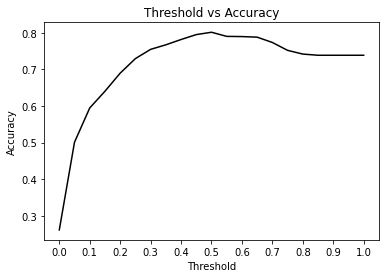

In [102]:
plt.figure(figsize=(6, 4))

plt.plot(df_acc['threshold'].values, df_acc['accuracy'].values, color='black')

plt.title('Threshold vs Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')

plt.xticks(np.linspace(0, 1, 11))

# plt.savefig('04_threshold_accuracy.svg')

plt.show()

## Dummy baseline

Establishing a baseline is an important step in evaluating the performance of our predictive models. For this purpose, we often use a dummy model — a simple construct which consistently predicts the same outcome, regardless of the input features. In our case, it consistently outputs 'False'. 

By comparing the performance of our complex models against this baseline, we gain a clear understanding of their incremental improvement in predictive accuracy. 

In [103]:
# dummy model that outputs only False
size_val = len(y_val)
baseline = np.repeat(False, size_val)


printest('Full Model Accuracy', accuracy)
printest('Small Model Accuracy', accuracy)
printest('Baseline accuracy', accuracy_score(baseline, y_val))

Full Model Accuracy : 
 0.7672043010752688 

Small Model Accuracy : 
 0.7672043010752688 

Baseline accuracy : 
 0.7387096774193549 



Observing the performance of our models, we notice that the smaller model surpasses the naive baseline by a marginal 2%, while the larger model achieves a slightly better improvement of 6%. According to accuracy metrics, our model only offers a marginal improvement over a rudimentary model that categorizes all customers as non-churning and makes no effort to retain them. 

This phenomenon often arises in scenarios where there is class imbalance, a condition wherein one class outnumbers the other. This imbalance is indeed apparent in our dataset, where 74% of customers didn't churn while only 26% did. For this we need another metric that validate the model.

# Confusion Matrix and Measures


**Confusion Matrix for multiple classes**

The accuracy is a global measure in that it does not explicitly consider the classes that contribute to the error. A more detailed understanding can be achieved by noting the agreement and disagreement for specific classes between the actual and predicted labels in the validation or test set. 

Consider a typical dataset for the validation points with multiple classes,
$$\mathbf{D} =
\left( \begin{array}{c|cccc|c}
~    &X_{0}&X_{1}&\cdots & X_{d}  & Y\\
\hline
\mathbf{x}_{1} &1& x_{11}& \cdots&x_{1d}&y_1 \\
\vdots&\vdots&\vdots&\ddots&\vdots&\vdots\\
\mathbf{x}_{n}&1&x_{n1}&\cdots&x_{nd}&y_n
\end{array} \right).$$

The target values, denoted as $\mathbf{Y} = (y_1, \cdots, y_i, \cdots, y_n)$, are not binary; instead, each $y_i \in \{c_1, \cdots, c_k\}$ represents one of $k$ class labels. Here, $\mathcal{D}= \{\mathbf{D}_1,\mathbf{D}_2, \cdots,\mathbf{D}_k\}$ denotes the division of validation data according to their true class labels $y$.

The $j^{th}$ split for the target values $y_i$ on the validation set is defined as:

$$\mathbf{D}_j = \{\mathbf{x}_i | y_i = c_j\}$$

with $n_i = |\mathbf{D}_i|$ as the count of the true class $c_i$ within the validation set.

Another division is conducted based on the predicted values from the validation set, forming $\mathcal{R} = \{\mathbf{R}_1, \mathbf{R}_2, \cdots, \mathbf{R}_k\}$. This denotes that the $j^{th}$ partition for the predicted target value $\hat{y}_i$ on the validation set is:

$$\mathbf{R}_j = \{\mathbf{x}_i | \hat{y}_i = c_j\}$$

and $m_i = |\mathbf{R}_i|$ represents the quantity of the predicted class $c_j$.

The divisions $\mathcal{R}$ and $\mathcal{D}$ yield a $k \times k$ matrix $\mathbf{N}$, better known as a confusion matrix. This matrix illustrates the intersections of each partition from the sets $\mathcal{R}$ and $\mathcal{D}$:

$$\mathbf{N}(i,j) = n_{ij} = |\mathbf{R}_i \cap \mathbf{D}_j |  = |\{\mathbf{x}_a \in \mathbf{D}| \hat{y}_a = c_j ~~\text{and} ~~ y_a = c_i \}|$$

For $1\leq i$, $j \leq k$, $n_{ij}$ represents the count of instances with a predicted class of $c_i$ and an actual label of $c_j$. These matrix values account for the total instances in each intersection. The matrix is presented as:

$$\mathbf{N} =
\left( \begin{array}{c|cccc}
~  y_{i} |~~\hat{y}_i  &c_{1}&c_{2}&\cdots & c_{k} \\
\hline
{c}_{1} &n_{11}& n_{12}& \cdots&n_{1k} \\
{c}_{2} &n_{21}& n_{22}& \cdots&n_{2k} \\
\vdots&\vdots&\vdots&\ddots&\vdots&\\
c_{k}&n_{k1}&n_{k2}&\cdots&n_{kk}
\end{array} \right).$$

The diagonal elements, $n_{ii} = |\mathbf{R}_i \cap \mathbf{D}_i|$ (for $1\leq i \leq k$), denote instances where the classifier correctly identifies the true label $c_i$. The size of $\mathbf{R}_i$ (the set of instances predicted as class $c_i$) and $\mathbf{D}i$ (the set of instances that are truly class $c_i$) and their relationship with $n_{ii}$ can provide further insights:

- If the size of $\mathbf{R}_i$ is equal to the size of $\mathbf{D}_i$, and $n_{ii}$ equals to the size of these sets, then the classifier has made perfect predictions for class $c_i$.

- If the size of $\mathbf{R}_i$ is larger than the size of $\mathbf{D}_i$, it means that the classifier has predicted more instances as class $c_i$ than there actually are.

- If the size of $\mathbf{R}_i$ is smaller than the size of $\mathbf{D}_i$, it means that the classifier has predicted fewer instances as class $c_i$ than there actually are.

The off-diagonal elements, $n_{ij} = |\mathbf{R}_i \cap \mathbf{D}_j|$ where $i \neq j$, represent instances where the classifier's predictions and the true labels diverge. If $n_{ij}$ is non-zero, it signifies that there are instances where the classifier predicted class $c_i$ while the true class was $c_j$, indicating a misclassification error.

- If the size of $\mathbf{R}_i$ is larger than the size of $\mathbf{D}_j$, it suggests that the classifier has over-predicted instances as class $c_i$ when they are actually class $c_j$. 

- If the size of $\mathbf{R}_i$ is smaller than the size of $\mathbf{D}_j$, it implies that the classifier has under-predicted instances as class $c_i$ when they are actually class $c_j$. 

To measure the quality of the classifier, we can calculate rates with respect to the sizes of each subset and their intersection:

**Accuracy/Precision**

The precision for a specific class $c_i$ is defined as the proportion of accurate predictions out of all points predicted to belong to class $c_i$:

$$\text{acc}_i = \text{prec}_i= \frac{|\mathbf{R}_i \cap \mathbf{D}_i | }{|\mathbf{R}_i|}  = \frac{n_{ii}}{m_i}$$

Here, $m_i$ is the total number of predictions for class $c_i$, and $n_{ii}$ represents instances where the classifier correctly identifies the true label $c_i$. A high precision for class $c_i$ indicates a more effective classifier.

**Covarage/Recall**

Recall, also known as coverage, for class $c_i$ is determined by the ratio of correct predictions to all points actually in class $c_i$:

$$\text{coverage}_i= \text{recall}_i = \frac{|\mathbf{R}_i \cap \mathbf{D}_i | }{|\mathbf{D}_i|} =  \frac{n_{ii}}{n_i}$$

Here, $n_i$ denotes the number of instances in class $c_i$. A high recall for class $c_i$ implies a more capable classifier.

**F-Measures**

Precision and recall often present a trade-off when assessing classifier performance. The F-measure seeks to balance these values by calculating their harmonic mean for class $c_i$:

- If $\text{recall}_i = 1$, the classifier predicts all validation points as belonging to class $c_i$. However, this will usually result in a low precision $\text{prec}_i$.

- If $\text{prec}_i$ is very high because the classifier predicts only a few points as $c_i$, the recall $\text{recall}_i$ is likely to be low.

The F-measure seeks to harmonize the precision and recall values by calculating their harmonic mean for class $c_i$:

$$F_i = \frac{2}{\frac{1}{\text{prec}_i} + \frac{1}{\text{recall}_i}} = \frac{2\text{prec}_i \text{recall}_i}{\text{prec}_i + \text{recall}_i} = \frac{2n_{ii}}{n_i + m_i}$$

The higher the $F_i$ value, the more effective the classifier for the specific class.

The overall F- measure for the classifier is the mean of the class-specific values:

$$F = \frac{1}{k}\sum^r_{i=1}F_i$$

For perfect classifier, the maximum value of F measure is 1.


**Confusion Matrix for Binary classes**

After considering a general case of multiple classes, we now turn our focus to the specific instance of binary classification. In such a scenario, where $k = 2$, we designate $c_0 = c_{~-}$ as the negative class and $c_1 = c_{~+}$ as the positive class. The target values are represented as $\mathbf{Y} = (c_{~-}, c_{~+})$. Consequently, the sets of true values are denoted as $\mathcal{D} = \{\mathbf{D}_{~-}, \mathbf{D}_{~+}\}$, and the predicted values are indicated as $\mathcal{R} = \{\mathbf{R}_{~-}, \mathbf{R}_{~+}\} $. The divisions $\mathcal{R}$ and $\mathcal{D}$ form a $2 \times 2$ matrix, as presented below:

$$\mathbf{N} =
\left( \begin{array}{c|cc}
~  y_{i} |~~\hat{y}_i  &c_{~-}& c_{~+} \\
\hline
{c}_{~-} &n_{00}& n_{01}&  \\
{c}_{~+} &n_{10}& n_{11}&  \\
\end{array} \right).$$

Each entry of the matrix corresponds to the size of the intersection of the subsets $n_{ij} = |\mathbf{R}_i \cap \mathbf{D}_j |$ for $i,j = \{-,+\} = \{0, 1\}$. In the context of binary classification, each entry of the matrix is given a specific name:


- **True Negatives (TN)**: The number of points that the classifier correctly predicts as negative:

  $$\text{TN} = n_{00} = |\mathbf{R}_{~-} \cap \mathbf{D}_{~-} | = |\{\mathbf{x}_i|\hat{y}_i = y_i = c_{~-}\}|$$

- **False Negatives (FN)**: The number of points the classifier predicts to be in the negative class, wich in fact belongs to the positive class: 

  $$\text{FN} = n_{10} = |\mathbf{R}_{~-} \cap \mathbf{D}_{~+} | = |\{\mathbf{x}_i|\hat{y}_i = c_{~-}~~\text{and}~~ y_i = c_{~+}\}|$$

- **False Positives (FP)**:The number of points the classifier predicts to be positive, wich in fact belong to the negative class:

  $$\text{FP} = n_{01} = |\mathbf{R}_{~+} \cap \mathbf{D}_{~-} | = |\{\mathbf{x}_i|\hat{y}_i = c_{~+}~~\text{and}~~ y_i = c_{~-}\}|$$
 


- **True Positives (TP)**: the number of points that the classifier correctly predicts as positive:
  
  $$\text{TP} = n_{11} = |\mathbf{R}_{~+} \cap \mathbf{D}_{~+} | = |\{\mathbf{x}_i|\hat{y}_i = y_i = c_{~+}\}|$$
As an example, let's consider a dataset of customers and their 'churn' status. Here, $c_{~-}$ represents no churn and $c_{~+}$ indicates churn. Using a validation dataset, we can distribute all customers across the categories defined above.

<center><img src = "Images/sets_confusion_matrix.png" width="500" height="400"/></center>

- **True Positives (TP)**: "churn" events correctly predicted as "churn".
- **True Negatives (TN)**: "not churn" events correctly predicted as "not churn".
- **False Positives (FP)**: "not churn" events incorrectly predicted as "churn".
- **False Negatives (FN)**: "churn" events incorrectly predicted as "not churn".


**Global Measures**

Global measures of the classifier performance

- **Error rate**: The proportion of incorrect predictions:

$$\text{Error Rate} = \frac{\text{FP} + \text{FN}}{n}$$

- **Accuracy**: The proportion of correct predictions:

$$\text{Accuracy} = \frac{\text{TP} + \text{TN}}{n}$$

where $n$ is the total points in the validation dataset.

**Class Specific Measures**

- **Precision**: The ratio of correct predictions to all points predicted to belong to the positive or negative class

 $$\text{prec}_i = \frac{n_{ii}}{m_i} = \left\{ \begin{array}{ll} 
\frac{n_{00}}{m_{~-}} = \frac{\text{TN}}{\text{TN}+\text{FN}} \\
\\
\\
\frac{n_{11}}{m_{~+}} = \frac{\text{TP}}{\text{TP}+\text{FP}}
\end{array}\right.$$

 where $m_i = |\mathbf{R}_i|$ is the size of the set for predicted class $c_i$

- **Recall**: The ratio of correct predictions out of all points in the positive or negative class.
  
  - **True Negative Rate (Specificity)**: 

  $$\text{recall}_{~-} = \text{specificity}= \frac{n_{00}}{n_{~-}} =\frac{\text{TN}}{\text{TN} +\text{FP}}  $$

   where $n_{~-} = |\mathbf{D}_{~-}| = \text{TN} +\text{FP}$ is the size of the set for true negative class.

  - **True Positive Rate (Sensitivity)**:

  $$\text{recall}_{~+} = \text{sensitivity} = \frac{n_{11}}{n_{~+}}  = \frac{\text{TP}}{\text{TP} +\text{FN}} $$

  where $n_{~+} = |\mathbf{D}_{~+}| = \text{TP} +\text{FN}$  is the size of the set for true positive class.

- **$1 -$ Recall** : The ratio of incorrect predictions to all points in the positive or negative class.

  - **False Negative Rate (FNR)**:
    
    $$1- \text{sensitivity} = \frac{n_{10}}{n_{~+}} =  \frac{\text{FN}}{\text{TP} +\text{FN}}$$
    
  - **False Positive Rate (FPR)**:

    $$1- \text{specificity} = \frac{ n_{01} } {n_{~-}} =  \frac{ \text{FP} }{\text{TN} +\text{FP} }$$


Now let's translate all these to python code:

In [104]:
# & stands as the intersection of the subsets
predict_churn = (y_pred >= 0.5)
predict_no_churn = (y_pred < 0.5)
actual_churn = (y_val == 1)
actual_no_churn = (y_val == 0)

true_positive = (predict_churn & actual_churn).sum()
false_positive = (predict_churn & actual_no_churn).sum()
false_negative = (predict_no_churn & actual_churn).sum()
true_negative = (predict_no_churn  & actual_no_churn).sum()

confusion_matrix = np.array(
     # predict neg    pos
    [[true_negative, false_positive], # actual neg
     [false_negative, true_positive]]) # actual pos

printest('Confusion matrix', confusion_matrix)

printest('Confusion matrix %', (confusion_matrix/confusion_matrix.sum()).round(3))

Confusion matrix : 
 [[1202  172]
 [ 197  289]] 

Confusion matrix % : 
 [[0.646 0.092]
 [0.106 0.155]] 



Our model performs reasonably well in predicting negative outcomes, correctly identifying them 65% of the time. However, there are still areas for improvement, as some errors do occur. The model incorrectly predicts positive outcomes 9% of the time and also misses positive outcomes 11% of the time.

| | Predicted False| Predicted True|
|---| --- | --- | 
|Actual False| 1202 (65%)  | 172 (9%)|
|Actual True| 197 (11%) | 289 (15%)|

As we can see, the model could benefit from further refinement to reduce the number of false predictions and increase its overall accuracy. The values from the confusion table serve as the basis for many other evaluation metrics. For example, we can calculate accuracy as we did before:

$$\text{accuracy} = \frac{(\text{TN} + \text{TP})}{n}=\frac{(\text{TN} + \text{TP})}{\text{TN} + \text{TP} + \text{FN} + \text{FP}} = \frac{1491}{1860} = 80\%$$

**Reminder**: 

In binary classification problems, "positive" refers to the occurrence of the event, behavior, or characteristic we are interested in, while "negative" refers to the non-occurrence. This doesn't necessarily correspond to the numeric values 1 and 0.

In the churn dataset case, classifying customers as "churn" (1) or "not churn" (0), we consider a "churn" event as "positive" because it's the outcome we're specifically interested in detecting. Hence, "positive" refers to "churn" and "negative" refers to "not churn".

## Precision and recall

Global metrics, like accuracy can be misleading when dealing with imbalanced
datasets such as ours. Both precision and recall are calculated from the values of the confusion table. They both help us understand the quality of the model in cases of class imbalance. Remember:

- **Precision**: Ratio of correct predictions out of all points that are predicted to belong to a class
  
 $$\text{prec}_i = \frac{n_{ii}}{m_i} = \left\{ \begin{array}{ll} 
\frac{n_{00}}{m_{~-}} = \frac{\text{TN}}{\text{TN}+\text{FN}} \\
\\
\\
\frac{n_{11}}{m_{~+}} = \frac{\text{TP}}{\text{TP}+\text{FP}}
\end{array}\right.$$

where $m_i$ represents the total number of points that are predicted to belong to class $c_i$.

- **Recall**: Ratio of correct predictions out of all points that actually belong to a class.

 $$\text{recall}_i = \frac{n_{ii}}{n_i} = \left\{ \begin{array}{ll} 
\frac{n_{00}}{n_{~-}} = \frac{\text{TN}}{\text{TN}+\text{FP}} \\
\\
\\
\frac{n_{11}}{n_{~+}} = \frac{\text{TP}}{\text{TP}+\text{FN}}
\end{array}\right.$$

where $n_i$ the total number of points that actually belong to class $c_i$.

In [105]:
# For true positive (churn)

prec_tp = true_positive/(true_positive + false_positive)
recall_tp = true_positive/(true_positive + false_negative)


printest('precision TP',prec_tp.round(3) )
printest('recall TP',recall_tp.round(3) )


precision TP : 
 0.627 

recall TP : 
 0.595 



Precision and recall are valuable metrics for understanding the effectiveness of our promotional messages.  Looking at the metrics in the table below:

| Metrics | True Positive (TP) | 
| --- | --- |
| Precision | 62% |
| Recall | 59% | 
 

we can interpret them as follows:

- **Precision (TP)**: Refers to the proportion of predicted positive instances that were correctly identified. In this case, a precision of 62% means that 62% of the customers we predicted would churn actually did churn, while the remaining 38% (false positives) did not churn despite our predictions.

- **Recall (TP)**:  Refers to the proportion of actual positive instances that were correctly identified. Here, a recall of 59% means we correctly identified 59% of all customers who did churn. However, we missed 41% of customers who actually churned because our model predicted they would not churn (false negatives).

In most cases, especially with imbalanced datasets, the primary focus is on the minority class, in this case, the customers who are churning. Our primary goal is to identify customers who will churn (True Positives) and **minimize the false negatives and false positives**. Hence, precision and recall for the True Positive class are the most commonly used metrics in such scenarios. 

# ROC curve and AUC score

**ROC Curve**

The Receiver Operating Characteristic (ROC) curve is a graphical representation of the performance of a binary classifier as the decision threshold is varied. Traditionally, we utilize a threshold of $t = 0.5$, as we did until now, but the ROC curve enables us to visualize the performance across all possible thresholds.

In our churn prediction model, $P(Y|\mathbf{x}_i) < t$ is the predicted probability of a customer not churning, whereas $P(Y|\mathbf{x}_i) \geq t$ is the predicted probability of a customer churning. Here, $t$ represents the different thresholds that we will examine.

The ROC curve represents the True Positive Rate (TPR) or sensitivity (y-axis) against the False Positive Rate (FPR) or 1-specificity (x-axis) as the decision threshold varies. Each point on the ROC curve corresponds to a unique pair of TPR and FPR values associated with a specific decision threshold.

For each distinctive score, we plot a point with the coordinates:

$$(FPR, TPR) = (\frac{ n_{01} } {n_{~-}},\frac{n_{11}}{n_{~+}})$$

Remember that: 
    
  - **False Positive Rate (FPR)**: Ratio of actual negative instances (i.e., customers who not churn) that are incorrectly identified as positive (i.e., predicted to churn)

    $$\text{FPR} = \frac{ n_{01} } {n_{~-}} =  \frac{ \text{FP} }{\text{TN}+\text{FP} }$$ 
  
  - **True Positive Rate (Sensitivity)**: Ratio of actual positive instances (i.e., customers who churned) that are correctly identified as such.

  $$ \text{TPR} = \frac{n_{11}}{n_{~+}}  = \frac{\text{TP}}{\text{TP} +\text{FN}} $$

**AUC Score**

The Area Under the Curve (AUC) is a metric that captures the performance of a binary classifier, as illustrated by the Receiver Operating Characteristic (ROC) curve.

In our churn dataset scenario:

- If the classifier perfect predicts (i.e., every prediction matches the actual outcome), the ROC curve will stretch to the plot's top left corner, given an AUC score of 1. This condition also corresponds to an ideal situation where there's no overlap between the scores for the two classes, indicating perfect discrimination.

- On the other hand, if a classifier cannot discriminate between the classes at all (i.e., it identifies equal numbers of false positives and true positives across all thresholds), the ROC curve will form a 45-degree diagonal line on the plot, which means the AUC is 0.5, an indication of random guessing.

The advantage of the AUC-ROC metric is the reliable measure of the model's performance, regardless of whether the dataset is balanced or imbalanced.


**TPR and FPR**

We're going to take a closer look at how the True Positive Ratio (TPR) and the False Positive Ratio (FPR) change as we adjust our decision thresholds. We'll do this by comparing three different models: our real model, a random one, and an ideal one. By contrasting these models, we can gain a clearer understanding of TPR and FPR. So, let's dive in and see how these ratios work across these different scenarios.

**Actual Model**

In [106]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        tp = ((y_pred >= t) & (y_val == 1)).sum()
        fp = ((y_pred >= t) & (y_val == 0)).sum()
        fn = ((y_pred < t) & (y_val == 1)).sum()
        tn = ((y_pred < t) & (y_val == 0)).sum()

        scores.append((t, tp, fp, fn, tn))

    df_scores = pd.DataFrame(scores)
    df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

In [107]:
df_scores = tpr_fpr_dataframe(y_val, y_pred)
display(df_scores.head())

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.00,486,1374,0,0,1.000000,1.000000
1,0.01,483,1190,3,184,0.993827,0.866084
2,0.02,481,1074,5,300,0.989712,0.781659
3,0.03,478,1011,8,363,0.983539,0.735808
4,0.04,478,970,8,404,0.983539,0.705968


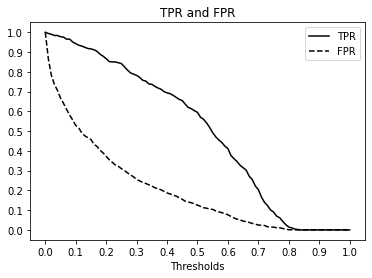

In [108]:
plt.figure(figsize=(6, 4))

# plot true positive ratio
plt.plot(df_scores.threshold, df_scores.tpr, color='black', linestyle='solid', label='TPR')

# plot false positive ratio
plt.plot(df_scores.threshold, df_scores.fpr, color='black', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel('Thresholds')
plt.title('TPR and FPR')

# plt.savefig('04_fpr_tpr_plot.svg')

plt.show()

Both the True Positive Rate (TPR) and False Positive Rate (FPR) start at 100% when the threshold is set to $t = 0.0$, where $P(Y|\mathbf{x}_i) \geq t$ , implying that all customers are predicted as churners. This happens because all probabilities are $P(Y|\mathbf{x}_i) \geq 0$, leading to the classification of every customer as a churner.

- At 100% FPR, every customer who not churn (negative instance) is wrongly predict as a churner, which is a false positive. This means we have no true negatives; we're not correctly identifying anyone who won't churn.

- The TPR is 100% because all actual churners (positive instances) are correctly identified as churners (true positives). That's why there are no false negatives; all churners are identified.

As the threshold is raised, both metrics start to decline, but at different paces.

In an ideal situation, the FPR reduce rapidly. A low FPR means that the model rarely misclassifies negative instances, minimizing false positives. On the other hand, we desire that TPR decrease slowly, maintaining a value near 100% as long as possible. This would indicate that the model effectively identifies true positives.

**Random Model**

A random model outputs a random score between 0 and 1, regardless of the input

In [109]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))
df_rand = tpr_fpr_dataframe(y_val, y_rand)

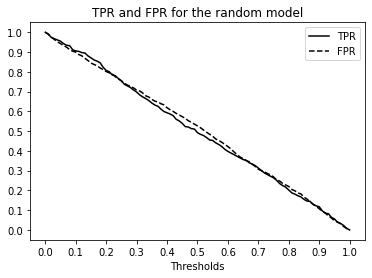

In [110]:
plt.figure(figsize=(6, 4))

plt.plot(df_rand.threshold, df_rand.tpr, color='black', linestyle='solid', label='TPR')
plt.plot(df_rand.threshold, df_rand.fpr, color='black', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel('Thresholds')
plt.title('TPR and FPR for the random model')

#plt.savefig('04_fpr_tpr_plot_random.svg')

plt.show()

In this model, both True Positive Rate (TPR) and False Positive Rate (FPR) begin at 100% and eventually fall to 0%.

At a threshold of 0.0, all customers are predicted to churn, yielding a 100% FPR (false positives) and TPR (true positives).

As we raise the threshold, both rates decline. At a 0.4 threshold, 60% of predictions are accurate for both churners and non-churners.

At a 1.0 threshold, we predict everyone as non-churning, bringing both FPR and TPR to 0%, meaning there are no true positives and all non-churners are correctly identified.

**Ideal Model**

In [111]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_pred_ideal = np.linspace(0, 1, num_neg + num_pos)

df_ideal = tpr_fpr_dataframe(y_ideal, y_pred_ideal)

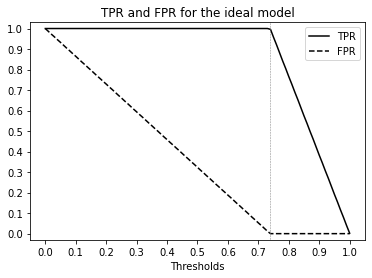

In [112]:
plt.figure(figsize=(6, 4))

plt.plot(df_ideal.threshold, df_ideal.tpr, color='black', linestyle='solid', label='TPR')
plt.plot(df_ideal.threshold, df_ideal.fpr, color='black', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.vlines(1 - y_val.mean(), -1, 2, linewidth=0.5, linestyle='dashed', color='grey')
plt.ylim(-0.03, 1.03)

plt.xlabel('Thresholds')
plt.title('TPR and FPR for the ideal model')

# plt.savefig('04_fpr_tpr_plot_ideal.svg')

plt.show()

**ROC Curve and AUC**

To create an ROC curve, instead of plotting FPR and TPR against different threshold
values, we plot them against each other

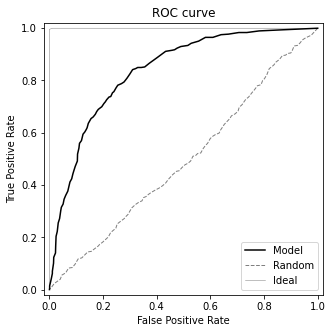

In [113]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, color='black', label='Model')
plt.plot(df_rand.fpr, df_rand.tpr, color='black', lw=1,
         linestyle='dashed', alpha=0.5, label='Random')
plt.plot(df_ideal.fpr, df_ideal.tpr, color='black', lw=0.5,
         linestyle='solid', alpha=0.5, label='Ideal')

plt.legend()

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

# plt.savefig('04_roc_curve_with_baselines.svg')

plt.show()

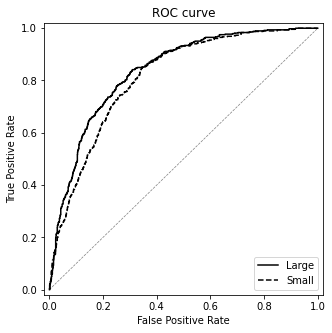

In [114]:
fpr_large, tpr_large, thresholds = roc_curve(y_val, y_pred)
fpr_small, tpr_small, thresholds = roc_curve(y_val, y_pred_small)

plt.figure(figsize=(5, 5))

plt.plot(fpr_large, tpr_large, color='black', linestyle='solid', label='Large')
plt.plot(fpr_small, tpr_small, color='black', linestyle='dashed', label='Small')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')
plt.legend(loc='lower right')

plt.show()

Our models should always be somewhere between these two curves. We want our
model to be as close to the ideal curve as possible and as far as possible from the random
curve.

The top-left corner is called the “ideal spot”: it’s the point when the ideal
model gets 100% TPR and 0% FPR.

In [115]:
df_scores_small = tpr_fpr_dataframe(y_val, y_pred_small)
auc_large = auc(df_scores.fpr, df_scores.tpr)
auc_small = auc(df_scores.fpr, df_scores.tpr)


printest('AUC large model',auc_large)
printest('AUC Small model',auc_small)

AUC large model : 
 0.8359001084215382 

AUC Small model : 
 0.8359001084215382 



An AUC of 0.9 is indicative of a reasonably good model; 0.8 is
okay, 0.7 is not very performant, and 0.6 indicates quite poor performance.

The AUC can be interpreted as the probability that a randomly chosen positive instance will have a higher predicted score than a randomly chosen negative instance.

To illustrate, consider randomly selecting one customer who churned and another who did not. Ideally, our prediction model should attribute a higher score to the customer who churned when compared to the customer who didn't churn. This score signifies the likelihood of churning.

To empirically validate this interpretation of AUC, we could simulate this scenario 10,000 times. For each iteration, we randomly select one positive instance and one negative instance and compare their predicted scores. If the score for the positive instance is consistently higher than the score for the negative instance, this demonstrates that our model is indeed effective at distinguishing between customers who are likely to churn and those who are not.

In [116]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

np.random.seed(1)
neg_choice = np.random.randint(low=0, high=len(neg), size=10000)
pos_choice = np.random.randint(low=0, high=len(pos), size=10000)
(pos[pos_choice] > neg[neg_choice]).mean()

0.8356

# Parameter Tuning

**k-Fold Cross-Validation**

Cross-validation is a technique where we divide the dataset, $\mathbf{D}$, into $k$ parts of equal size, which we call folds (e.g., $\mathbf{D}_1,\mathbf{D}_2, \cdots, \mathbf{D}_k$). Each fold, $\mathbf{D}_i$, is used as a testing set one time, with the rest serving as the training set. 

To illustrate, consider we have a dataset and we choose $k=3$. The dataset is divided into 3 subsets or folds. In each iteration, we use one fold as the test set and the remaining folds as the training set, as show below:


<center><img src = "Images/k_fold_cv.png" width="400" height="200"/></center>


So in each iteration, the model is trained on the training set and its performance is evaluated on the testing set, $\mathbf{D}_i$, to obtain the $i^{th}$ estimate, $\theta_i$.

From there, we can estimate the average performance measure as:

$$\hat{\mu}_{\theta} = \mathbf{E}[\theta] = \frac{1}{k}\sum_{i=1}^{k}\theta_i$$ 

We can also calculate the variance of the performance measure as:

$$\hat{\sigma}_{\theta}^2 = \frac{1}{k}\sum_{i=1}^{k}(\theta_i -\hat{\mu}_{\theta})^2$$ 

The process starts by randomly shuffling the dataset, $\mathbf{D}$, then split it into $k$ equal parts. In each round of validation, one fold, $\mathbf{D}_i$, serves as the testing set, and the model's performance, $\theta_i$, is assessed. The process is repeated multiple times with different shuffles of the data to ensure the results are reliable.

Typically, we choose $k$ as either 5 or 10.

The Python code for implementing this process is as follows:

In [117]:
def train(df, y):
    df_dict = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(df_dict)

    x_train = dv.transform(df_dict)

    model = LogisticRegression(solver='liblinear')
    model.fit(x_train, y)

    return dv, model


def predict(df, dv, model):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(cat)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

Here we used K-fold cross-validation with $K =10$. Thus, when we run it, at the end we
get 10 different numbers — 10 AUC scores evaluated on 10 different validation folds. We can think of it as a distribution of AUC scores for our model, making possible to get some statistic like mean and variance.

In [118]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

aucs = []

# for each fold, split the dataset into training and validation datasets
for train_idx, val_idx in kfold.split(df_train_full):
    
    # create training dataset using indices provided by k-fold object
    df_train = df_train_full.iloc[train_idx]
    y_train = df_train.churn.values

    df_val = df_train_full.iloc[val_idx]
    y_val = df_val.churn.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    # compute the AUC score and store it in the list
    rocauc = roc_auc_score(y_val, y_pred)
    aucs.append(rocauc)


# print AUC for each fold
printest('AUCs',np.array(aucs).round(3))

# print mean and standard deviation of AUCs across all folds
print('AUC stats = %0.3f ± %0.3f' % (np.mean(aucs), np.std(aucs)))

AUCs : 
 [0.849 0.841 0.859 0.833 0.824 0.841 0.844 0.824 0.845 0.861] 

AUC stats = 0.842 ± 0.012


**Tuning the parameter `C`**

In logistic regression, a component known as the regularization term is incorporated into the cost function. This term operates by introducing a penalty to the cost function, analogous to the L1 regularization for linear regression. The penalty term helps prevent the model from overfitting by limiting the magnitude of the model parameters.

The strength of the regularization is controlled by the C parameter. A smaller C means stronger regularization, leading to smaller model parameters, whereas a larger C corresponds to weaker regularization, allowing the model parameters to take larger values.

Thus, by adjusting C, we can control the balance between keeping the model simple to avoid overfitting and allowing it to fit the training data as closely as possible.

In [119]:
def train(df, y, C=1.0):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X, y)

    return dv, model

In [120]:
nfolds = 5
kfold = KFold(n_splits = nfolds, shuffle=True, random_state=1)

for C in [0.001, 0.01, 0.1, 0.5, 1, 10]:
    aucs = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    #print('C=%s, auc = %0.3f ± %0.3f' % (C, np.mean(aucs), np.std(aucs)))

| `C` Value | AUC: $\mu \pm  \sigma$  |
| --------- | ---------- |
| 0.001     | 0.825 ± 0.013 |
| 0.01      | 0.839 ± 0.009 |
| 0.1       | 0.841 ± 0.007 |
| 0.5       | 0.841 ± 0.007 |
| 1         | 0.841 ± 0.007 |
| 10        | 0.841 ± 0.007 |



We can observe that beyond $C=0.1$, the average AUC remains consistent and no longer increases. This indicates that a C value of $0.1$ is sufficient to maximize the model's predictive power.

However, when comparing the models using $C=0.5$ and $C=0.1$, the model with $C=0.5$ has a smaller standard deviation, indicating a more stable model performance across different folds. Given this, we would favor C=0.5 as it provides a more reliable model prediction.

Now for the last step, we train the model on the entire train and validation
datasets and apply it to the test dataset to verify it indeed works well for $C=0.5$

In [125]:
y_train = df_train_full.churn.values
y_test = df_test.churn.values

dv, model = train(df_train_full, y_train, C=0.5)
y_pred = predict(df_test, dv, model)

auc_05 = roc_auc_score(y_test, y_pred)
printest('AUC for c = 0.5', auc_05.round(3))

AUC for c = 0.5 : 
 0.858 



The AUC score on the test set is $0.858$, which, while it is higher than the validation score of $0.841 \pm 0.007$, is not drastically different. The difference between the test score and the validation score is slightly larger than the standard deviation from the cross-validation process, but it's still relatively close. This means that our model's performance on the test set is better than we estimated from cross-validation, but the difference is not so large that we would worry about overfitting to the training data. It shows that our model generalizes well to unseen data.